# Scaling with number of signals.
In the last notebook, we saw that in general, given a reservoir computer, we can construct an exponential number of new signals that, generally, can be used to improve learning. First, we show this more carefully. These networks are simple enough that there are only a few parameters: Training data length, Reservoir size, Spectral radius, Sparsity, Regularization coefficient and Bleedthrough coefficient.

For this notebook, we are going to set 3,4,5 and 6 heuristically, and focus on 1 and 2. These can be tuned to control overfitting and performance. We also are going to optimize our simulation to have a batch dimension. To reduce the complexity of the problem, we are going to consider a sum of sinusoids. The NARMA task is a good benchmark, and in general would likely require combinations of the powerset that also include multi-point correlated functions of time. Here, we consider the setting where we are receiving a signal that is some random sum of frequencies. This is simple, but can be thought of as first steps towards a Fourier learning algorithm. 

We're going to fix a very simple learning task - learning some collection of sinusoids. When considered as a signal processing tasks, this is simply learning the Fourier representation of a signal. In particular, we've assumed a bag of words model on the input, drawing uniformly at random from the interval. This is a good baseline, but could be improved by considering explicit correlations in a desired corpus that we were processing. Exhaustively using the power set is difficult, since the number of signals is exponential, but we can do it for small networks. 

We simply add on all elements of the power set. Additionally we have rewritten the simulation to batch over the data dimension. Our first claim is that the power set signals help. This is trivially true, since it's strictly more signals, but since we are interested in a scaling law, we'd really like an ensemble over many reservoirs. It's challenging to even enforce monotonicity since the new neurons interact with the old ones. That being said, we can sample from an ensemble, and we find generally that the powerset does better.  (Intuitively, products of sines have side bands, and so we expect the product signals to help.) We include ridge regression to avoid overfitting in the power set case.

To keep things maneagble, we will only look up to 10 neurons. The power set is already 1024 signals large. We need to fight over training, as well as numerical error incurred in the power set, since naive mulitiplication produces exponentially small numbers.

In [28]:
def fetchData(n):
    while True:
        u = 0.5 * np.random.uniform(low=0., high=1.0, size=(n+1000))
        freqs = [1,3,5,10,20]
        y = sum([np.sin(20*u) for freq in freqs])
        return (u, y)
        
def ESN_init(inSize, outSize, resSize, alpha, sparsity):
    Win = np.random.rand(inSize+1, resSize) - 0.5
    W = np.random.rand(resSize, resSize) - 0.5
    W[np.random.rand(resSize, resSize)>sparsity] = 0
    spec_rad = max(abs(np.linalg.eig(W)[0]))
    W /= spec_rad
    return Win, W, inSize, resSize, alpha, sparsity

In [29]:
def reservoir(data, Win, W, inSize, resSize, alpha, restart, batch_number, power_set):
    device = torch.device("mps")
    batch_size = len(data) // batch_number
    W = torch.tensor(W).float()
    W = torch.tensor(W, device=device)
    data = torch.tensor(data).float()
    data = torch.tensor(data, device=device)
    new_data = data.view(batch_number, batch_size)
    W_copies = W.repeat(batch_number, 1, 1).float()
    Win = torch.tensor(Win).float()
    Win = torch.tensor(Win, device=device)
    Win_copies = Win.repeat(batch_number, 1, 1)
    R_copies = .1 * (torch.ones((batch_number, resSize), device=device) - 0.5).float()
    dm = torch.zeros((batch_number, batch_size - 50, 1 + inSize + resSize), device=device).float()
    for t in range(batch_size):
        u = new_data[:, t].unsqueeze(1)
        ones = torch.ones(u.shape[0], 1, device=device)
        ones = torch.hstack((ones, u))
        R_copies = (1 - alpha)*R_copies +\
        alpha*torch.tanh(torch.einsum('ij,ijk->ik', ones,Win_copies) +\
                  torch.einsum('ij,ijk->ik', R_copies, W_copies))
        u = u.float()
        if t >= 50:
            dm[:, t-50, :] = torch.cat((ones, R_copies), dim=1)            
    dm = dm.view(-1, 1+inSize+resSize)
    new_data = new_data[:, 50:].flatten()
    s = list(dm.T)[2:]
    chosen_subsets = []
    if power_set:
        # Generate all subsets
        from itertools import combinations
        for subset_size in range(len(s)+1):  # +1 because range excludes the last number
            for subset in combinations(s, subset_size):
                chosen_subsets.append(list(subset))
    ones = torch.ones(new_data.shape[0]).numpy()
    chosen_subsets = [[l.cpu().numpy() for l in el] for el in chosen_subsets]
    power_signals = [reduce(lambda a, b: a*b, el, ones) for el in chosen_subsets] 
    power_signals = [torch.tensor(pw) for i,pw in enumerate(power_signals)]
    power_signals = [el.cpu() for el in list(dm.T)] + power_signals
    return torch.vstack(power_signals).T, new_data

In [30]:
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5,num_batches=2, powerset=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    data, Y = fetchData(train_cycles+test_cycles + 50*num_batches*2)
    data_train, Y_train = data[:train_cycles+50*num_batches], Y[:train_cycles+50*num_batches]
    data_test, Y_test = data[train_cycles+50:], Y[train_cycles+50:]
    batch_size = len(data_train) // num_batches
    data_train, Y_train = data_train[:batch_size*num_batches], Y_train[:batch_size*num_batches]
   
    # Cut out the warmup portions.
    Y_train = Y_train.reshape((num_batches, batch_size))  
    Y_train = Y_train[:, 50:].flatten()
    RA_Train, data_train = reservoir(data_train, *Echo, num_batches, powerset)
    ridge = np.zeros(tuple(RA_Train.shape))
    np.fill_diagonal(ridge, 1E-3) 
    Wout, _, _, _ = np.linalg.lstsq(RA_Train.cpu().float().numpy() + torch.tensor(ridge).float().numpy(), torch.tensor(Y_train).cpu().float().numpy(), rcond=0)
    batch_size = len(data_test) // num_batches
    data_test, Y_test = data_test[:batch_size*num_batches], Y_test[:batch_size*num_batches]
    RA_Test, _ = reservoir(data_test, *Echo, num_batches, powerset)
    Yhat = RA_Test.cpu() @ Wout
    Y_test = Y_test.reshape((num_batches, batch_size))  
    Y_test = Y_test[:, 50:].flatten()    
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test-Yhat.numpy().T)),np.var(Y_test)))
    return NRMSE, Y_test, Yhat, RA_Test



In [31]:
import numpy as np
import torch, random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from functools import reduce
np.random.seed(137)
random.seed(137)
batches = 1000
test_cycles=1000
# list to store all NRMSE values
all_nrmse = []
spacingx=1
spacingy=1000
# range for resSize and train_cycles
resSizes = np.arange(1, 10, spacingx)
train_steps = np.arange(1000, 110000, spacingy)
last_train_cycles = 0
NRMSE = np.inf
powerset = False
# Demonstrated loop for different sizes and cycles
for resSize in tqdm(resSizes):
    for train_cycles in train_steps:
        if train_cycles < last_train_cycles:
            continue
        train_cycles = batches * train_cycles // batches
        NRMSE, _, _, _ = test_NARMA10(resSize=resSize, num_batches=batches, train_cycles=train_cycles, test_cycles=test_cycles, powerset=powerset)
        # Append the NRMSE value and configuration to the listpower
        all_nrmse.append((NRMSE, resSize, train_cycles))
        
        # Save results with pickle after each iteration
        with open(f'results{powerset}.pkl', 'wb') as f:
            pickle.dump(all_nrmse, f)

        # break loop if performance decreases
        if len(all_nrmse) > 1 and all_nrmse[-1][0] > all_nrmse[-2][0]:
            last_train_cycles = train_cycles
            break

  0%|                                                     | 0/9 [00:00<?, ?it/s]/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_31105/2855340009.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_31105/2855340009.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_31105/2855340009.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Win

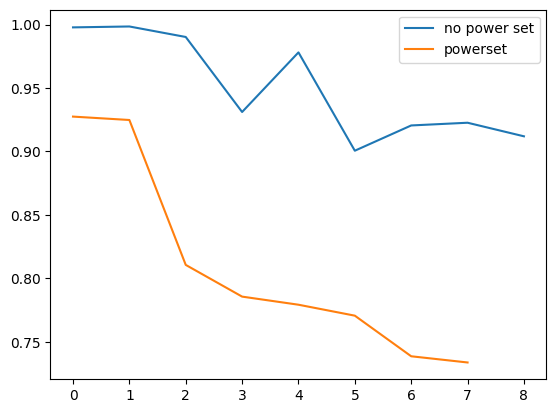

In [32]:
import pickle as pkl
import numpy as np
with open('resultsFalse.pkl', 'rb') as f:
    all_nrmse0 = pkl.load(f)
import numpy as np
with open('resultsTrue.pkl', 'rb') as f:
    all_nrmse1 = pkl.load(f)

a = np.array(all_nrmse0)
b = np.array(all_nrmse1)

import numpy as np
import matplotlib.pyplot as plt

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# Find the best values per size for each dataset
best_a = get_best_per_size(a)
best_b = get_best_per_size(b)
plt.plot(list(best_a.values()), label='no power set')
plt.plot(list(best_b.values()), label='powerset')
plt.legend()